# 올리브영 랭킹 사이트 크롤링!
-구매하고자 하는 제품이 특정한 경우가 아닌 이상 랭킹을 바탕으로 하여 브랜드, 상품의 인기를 확인
- 랭킹사이트의 여러 인사이트를 확인해보고자 프로젝트를 진행

In [1]:
# 크롤링을 하자
import requests
from bs4 import BeautifulSoup
# 판매랭킹 URL
URL  = 'https://www.oliveyoung.co.kr/store/main/getBestList.do' 
response = requests.get(URL)


In [2]:
print(response.status_code)
soup = BeautifulSoup(response.text, 'html.parser')

200


In [3]:
# 위 내용을 한번에 함수화
def oy_crawling(now_url):
    import requests
    from bs4 import BeautifulSoup
    
    # 판매랭킹 URL
    URL  = now_url
    response = requests.get(URL)
    soup = BeautifulSoup(response.text, 'html.parser')
    brands = soup.select(".cate_prd_list li .tx_brand") # 100개  # 브랜드 이름
    names = soup.select(".cate_prd_list li .tx_name") # 100개 # 상품이름
    current_prices = soup.select(".cate_prd_list li .tx_cur .tx_num") # 100개  # 현재 판매가(할인가)
    
    #TOP 100 브랜드, 상품명, 현재가 리스트 만들기
    brand_list = []
    name_list = []
    current_list = []
    for brand in brands :
        brand_list.append(brand.text.strip())
    for name in names:
        name_list.append(name.text.strip())
    for current_price in current_prices:
        current_list.append(current_price.text.strip())
    
    # 정가 리스트 만들기
    original_list = []
    count = 0
    tags = soup.select(".cate_prd_list li .prd_price")
    for tag in tags:
        if tag.select_one(".tx_org .tx_num"): # 정가랑 현재가랑 다름
            temp=tag.select_one(".tx_org .tx_num")
            count +=1
            original_list.append(temp.text.strip())
        else : # 정가랑 현재랑 같음 => 데이터가 존재하지 않아 직접 입력해야해 
            original_list.append(current_list[count])
            count +=1
    
    # 옵션 리스트 만들기
    coupon_list = []
    delivery_list = []
    sale_list = []
    gift_list = []
    otags = soup.select(".cate_prd_list li")
    for otag in otags:
    # 쿠폰여부 확인! 
        if otag.select_one(".icon_flag.coupon"): # 쿠폰클래스가 존재해
            coupon_list.append(True)
        else : # 쿠폰클래스가 존재하지 않음
            coupon_list.append(False)
        
    #세일여부 확인! 
        if otag.select_one(".icon_flag.sale"): # 증정 클래스가 존재해
            sale_list.append(True)
        else : # 증정 클래스가 존재하지 않음
            sale_list.append(False) 
        
    # 증정여부 확인! 
        if otag.select_one(".icon_flag.gift"): # 증정 클래스가 존재해
            gift_list.append(True)
        else : # 증정 클래스가 존재하지 않음
            gift_list.append(False)  
        
    # 오늘드림 서비스 여부 확인! 
        if otag.select_one(".icon_flag.delivery"): # 증정 클래스가 존재해
            delivery_list.append(True)
        else : # 증정 클래스가 존재하지 않음
            delivery_list.append(False)
        
    return brand_list, name_list, current_list, original_list, coupon_list,delivery_list,sale_list,gift_list

In [4]:
brand_list, name_list, current_list,original_list, coupon_list,delivery_list,sale_list,gift_list=oy_crawling('https://www.oliveyoung.co.kr/store/main/getBestList.do?dispCatNo=900000100100001&fltDispCatNo=&pageIdx=1&rowsPerPage=8')

In [5]:
# 모든 정보들을 하나의 리스트로 통합
oy_top100=[]
for i in range(100):
    oy_info  = {
        '순위':i+1,
        '브랜드': brand_list[i],
        '상품명': name_list[i], 
        '정가': original_list[i],
        '현재 판매가': current_list[i],
        '세일': sale_list[i],  
        '쿠폰': coupon_list[i], 
        '증정': gift_list[i], 
        '오늘드림': delivery_list[i]
    }
    oy_top100.append(oy_info)


In [6]:
# 경고무시
import warnings 
warnings.filterwarnings(action  = 'ignore')

## 랭킹이 많이 올라간 순서대로 브랜드 정렬하기

In [7]:
def let_brandcount_sort(brand_list):
    brand_set=set(brand_list) # 중복없는 브랜드 세트
    len(brand_set)
    distinct_brandlist=list(brand_set) #중복없는 브랜드 리스트
    
    import operator
    # 딕셔너리의 키에는 브랜드 이름, 값에는 랭킹빈도
    brand_dict = {}
    for i in range(len(brand_set)):
        temp=distinct_brandlist[i]
        brand_dict[temp]= brand_list.count(temp)
    
    # value가 많은순으로 정렬
    sort_brand_dict = sorted(brand_dict.items(),  key = lambda x : x[1],reverse= True)
    sort_brand_dict
    
    sorted_brandnames= []
    sorted_brandcount = []
    for i in range(len(sort_brand_dict)):
        sorted_brandnames.append(sort_brand_dict[i][0])
        sorted_brandcount.append(sort_brand_dict[i][1])
    return sorted_brandnames, sorted_brandcount,brand_dict

In [8]:
sorted_brandnames, sorted_brandcount,brand_dict =let_brandcount_sort(brand_list)

In [9]:
# 시각화 위해서
import seaborn as sns
import matplotlib.pyplot as plt

# 한글깨짐 처리
import platform
from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus']= False
if platform.system()=='Windows':
    path = 'c:/Windows/Fonts/malgun.ttf'
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family = font_name)
else :
    print("")

## 시각화 ( 그래프 )

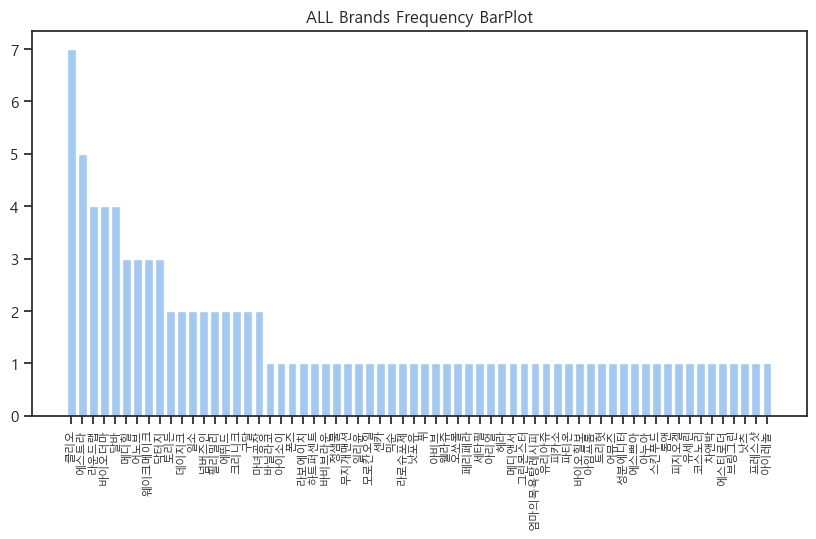

In [40]:
# 1. 어떠한 브랜드들이 랭킹에 몇 번 올라왔는지 확인!! 
x= sorted_brandnames
y = sorted_brandcount
# 전체 Barplot
plt.figure(figsize=(10, 5))
plt.bar(x=x, height=y) 
plt.title("ALL Brands Frequency BarPlot")
plt.xticks(fontsize =8, rotation=90)
plt.show()


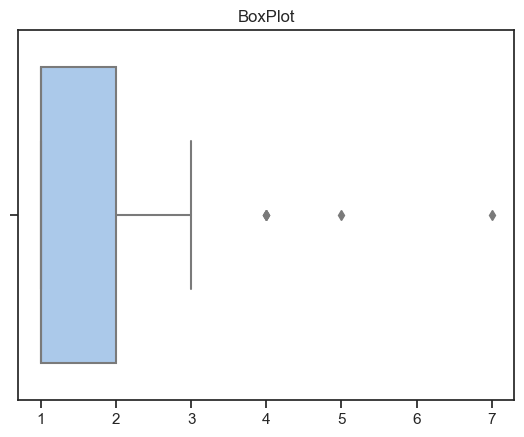

In [11]:
# count에 대한 boxplot을 그려서 상위 일부만 다시 barplot을 그려보자
sns.set_theme(style="ticks", palette="pastel")
sns.boxplot(sorted_brandcount)
plt.title("BoxPlot")
plt.show()

18


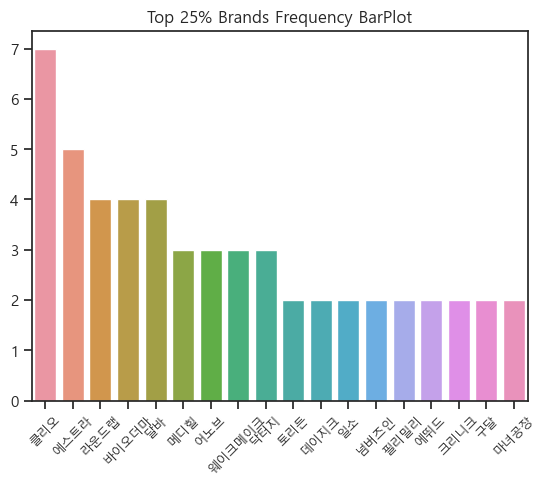

In [41]:
# 한글깨짐 처리
import platform
from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus']= False
if platform.system()=='Windows':
    path = 'c:/Windows/Fonts/malgun.ttf'
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family = font_name)
else :
    print("a")
    
# 위 두 결과를 보니 대체적으로 1,2개에 집중적이다. 그렇다면 count >=2이상만 countplot 다시 그려보자
for i in range(len(sorted_brandcount)):
    if sorted_brandcount[i]==1:
        break
print(i) ## 인덱스상으로 i번쨰부터 1이라는 것은 i-1번째까지는 2라는 뜻,
sns.barplot(x=x[:i], y=y[:i])
plt.title("Top 25% Brands Frequency BarPlot")
plt.xticks(fontsize = 9, rotation=45)
plt.show()

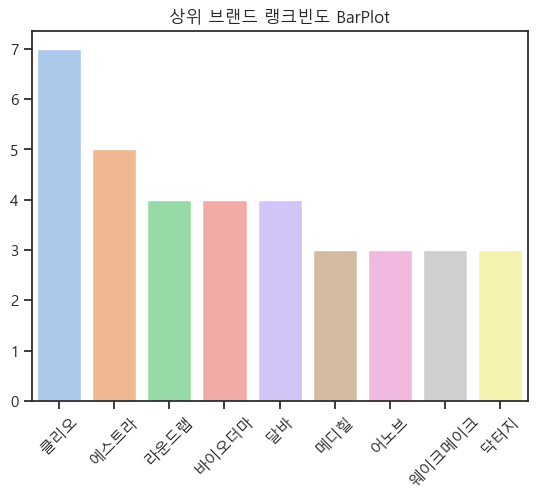

In [25]:
for i in range(len(sorted_brandcount)):
    if sorted_brandcount[i]==2:
        break
sns.barplot(x=x[:i], y=y[:i])
plt.title("상위 브랜드 랭크빈도 BarPlot")
plt.xticks(rotation=45)
plt.show()

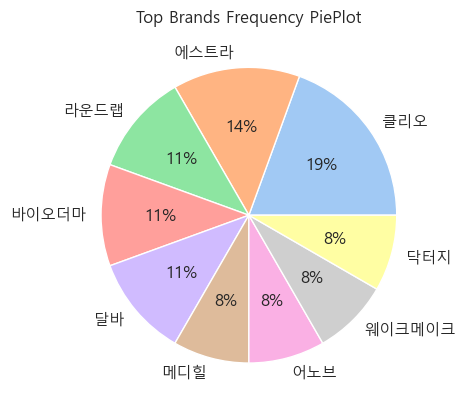

In [14]:
colors = sns.color_palette('pastel')
plt.pie(sorted_brandcount[:i], labels = sorted_brandnames[:i], colors=colors,autopct='%.0f%%')
plt.title("Top Brands Frequency PiePlot")
plt.show()

### 워드클라우드 활용 시각화

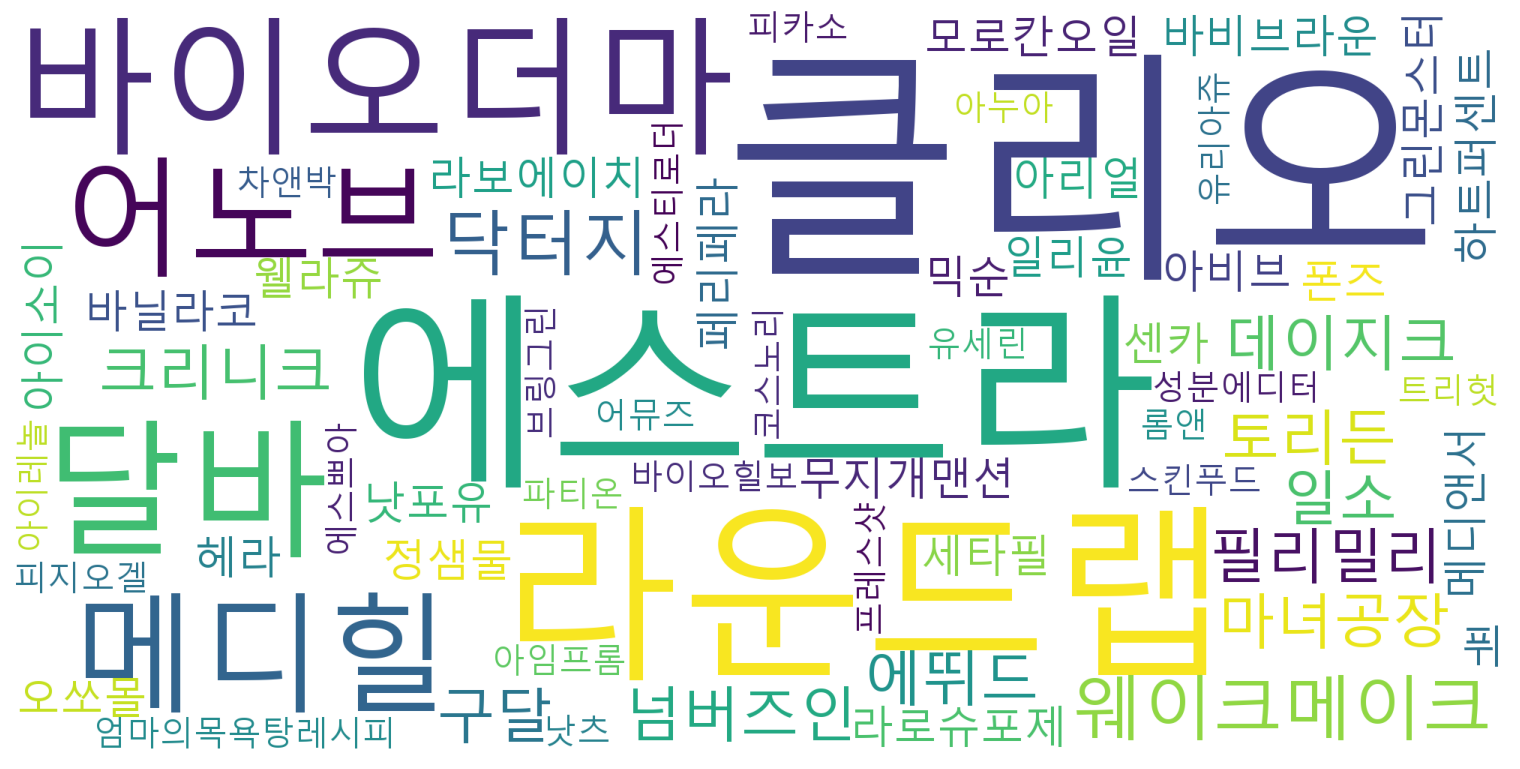

In [15]:
from wordcloud import WordCloud 
import matplotlib.pyplot as plt
import numpy as np
from PIL import *

word_cloud = WordCloud(font_path='C:/Windows/Fonts/malgun.ttf', width = 2000, height = 1000, background_color='white')
word_cloud.generate_from_frequencies(brand_dict)

plt.figure(figsize=(15,15))
plt.imshow(word_cloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()


### 두번째 분석
#### 상관관계? 옵션과 순위, 브랜드 랭크빈도수 분석 ( 점 양분 상관계수 활용)

- 점 양분 상관계수는 피어슨 상관 계수와 수학적으로 동일한 경우로 보일수있다. 즉, 변수 X와 이분법 변수 Y가 연속적으로 측정 된 경우에서 rXY = rpb이다. 이분법 변수에서 두 개의 별개의 숫자 값을 할당해봄으로써 이를 확인할 수 있다. (이진변수 & 연속형변수)

In [16]:
import numpy as np
from scipy import stats
# 옵션과 순위 분석
rank_list =[ i+1 for i in range(100)]
#세일
if sum(sale_list)==100 or sum(sale_list)==0:
    print("세일과 순위와의 상관관계")
    print('상관관계를 구할 수 없습니다. ')
else :
    print("세일과 순위와의 상관관계")
    print(stats.pointbiserialr(rank_list, sale_list) )
#증정
if sum(gift_list)==100 or sum(gift_list)== 0:
    print("증정과 순위와의 상관관계")
    print('상관관계를 구할 수 없습니다. ')
else :
    print("증정과 순위와의 상관관계")
    print(stats.pointbiserialr(rank_list,gift_list) )
# 쿠폰
if sum(coupon_list)==100 or sum(coupon_list)== 0:
    print("쿠폰과 순위와의 상관관계")
    print('상관관계를 구할 수 없습니다. ')
else :
    print("쿠폰과 순위와의 상관관계")
    print(stats.pointbiserialr(rank_list, coupon_list) )
#오늘드림
if sum(delivery_list)==100 or sum(delivery_list)== 0:
    print("오늘드림과 순위와의 상관관계")
    print('상관관계를 구할 수 없습니다. ')
else :
    print("오늘드림과 순위와의 상관관계")
    print(stats.pointbiserialr(rank_list, delivery_list) )


세일과 순위와의 상관관계
PointbiserialrResult(correlation=0.019149499654047535, pvalue=0.8500107150455881)
증정과 순위와의 상관관계
상관관계를 구할 수 없습니다. 
쿠폰과 순위와의 상관관계
PointbiserialrResult(correlation=0.1455284362842562, pvalue=0.1485446739503817)
오늘드림과 순위와의 상관관계
PointbiserialrResult(correlation=-0.01368751874938652, pvalue=0.8924848635941114)


In [17]:
# 브랜드 랭크빈도 리스트 만들기
count_list = []
for brand in brand_list:
    temp = sorted_brandnames.index(brand)
    count_list.append( sorted_brandcount[temp])

In [18]:
# 옵션과 브랜드 랭크빈도
#세일
if sum(sale_list)==100 or sum(sale_list)==0:
    print("세일과 브랜드랭크빈도와의 상관관계")
    print('상관관계를 구할 수 없습니다. ')
else :
    print("세일과 브랜드랭크빈도와의 상관관계")
    print(stats.pointbiserialr(count_list, sale_list) )
#증정
if sum(gift_list)==100 or sum(gift_list)==0:
    print("증정과 브랜드랭크빈도와의 상관관계")
    print('상관관계를 구할 수 없습니다. ')
else :
    print("증정과 브랜드랭크빈도와의 상관관계")
    print(stats.pointbiserialr(count_list,gift_list) )
# 쿠폰
if sum(coupon_list)==100 or sum(coupon_list)==0:
    print("쿠폰과 브랜드랭크빈도와의 상관관계")
    print('상관관계를 구할 수 없습니다. ')
else :
    print("쿠폰과 브랜드랭크빈도와의 상관관계")
    print(stats.pointbiserialr(count_list, coupon_list) )
#오늘드림
if sum(delivery_list)==100 or sum(delivery_list)==0:
    print("오늘드림과 브랜드랭크빈도와의 상관관계")
    print('상관관계를 구할 수 없습니다. ')
else :
    print("오늘드림과 브랜드랭크빈도와의 상관관계")
    print(stats.pointbiserialr(count_list, delivery_list) )



세일과 브랜드랭크빈도와의 상관관계
PointbiserialrResult(correlation=0.07991523694591987, pvalue=0.4293115542742202)
증정과 브랜드랭크빈도와의 상관관계
상관관계를 구할 수 없습니다. 
쿠폰과 브랜드랭크빈도와의 상관관계
PointbiserialrResult(correlation=-0.10490343118072047, pvalue=0.2989375050820442)
오늘드림과 브랜드랭크빈도와의 상관관계
PointbiserialrResult(correlation=0.22585226042471857, pvalue=0.023858177693396924)


In [19]:
# 브랜드랭크빈도와 랭크와는 상관관계가 있을까?
import pandas as pd
co_data = {"Rank": rank_list, "Frequency": count_list}
corr_data =pd.DataFrame(co_data)
print(corr_data.corr(method="pearson"))

               Rank  Frequency
Rank       1.000000  -0.201873
Frequency -0.201873   1.000000


In [20]:
# original_list, current_list 가공하기 함수화
def no_comma_int (one_list):
    new_list = []
    for one in one_list:
        new_list.append(int(one.replace(",","")))
    return new_list


### 가격들과 브랜드 랭킹 빈도수와의 상관관계 파악
-저렴한 가격대의 브랜드의 경우 랭킹을 많이 하지 않을까...?의 궁금증으로 부터 파생

브랜드 랭킹 빈도수와의 상관관계
                Original Price  Current Price  Frequency
Original Price        1.000000       0.927106  -0.079631
Current Price         0.927106       1.000000  -0.098864
Frequency            -0.079631      -0.098864   1.000000


<AxesSubplot:title={'center':'Correlation of Features'}>

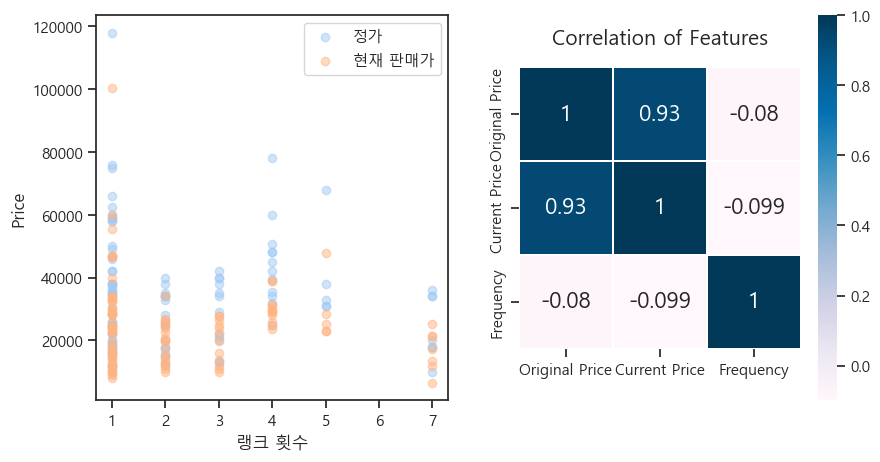

In [21]:
int_original_list=no_comma_int (original_list)
int_current_list=no_comma_int (current_list)
print("브랜드 랭킹 빈도수와의 상관관계")
data = {"Original Price":int_original_list,"Current Price":int_current_list,"Frequency": count_list,}
df =pd.DataFrame(data)

#1 산점도로 확인
plt.figure(figsize = (10,5))
grid = plt.GridSpec(1,2)
plt.subplot(grid[0,0])
plt.scatter(count_list, int_original_list, alpha= 0.5, label = "정가")
plt.scatter(count_list, int_current_list, alpha= 0.5, label = "현재 판매가")
plt.ylabel("Price")
plt.xlabel("랭크 횟수")
plt.legend()
# 히트맵으로 확인
print(df.corr(method="pearson"))
colormap = plt.cm.PuBu
plt.subplot(grid[0,1])
mask = np.zeros_like(df, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.title("Correlation of Features", y = 1.05, size = 15)
sns.heatmap(df.astype(float).corr(), linewidths = 0.1, vmax = 1.0,
           square = True, cmap = colormap, linecolor = "white", annot = True, annot_kws = {"size" : 16})

### 가격들과 순위와의 상관관계 파악
- 가격들이 저렴한 제품이라면 순위가 더 높지 않을까? 

현재 판매가와 순위와의 상관관계
                Original Price  Current Price      Rank
Original Price        1.000000       0.927106 -0.198611
Current Price         0.927106       1.000000 -0.185668
Rank                 -0.198611      -0.185668  1.000000


<AxesSubplot:title={'center':'Correlation of Features'}>

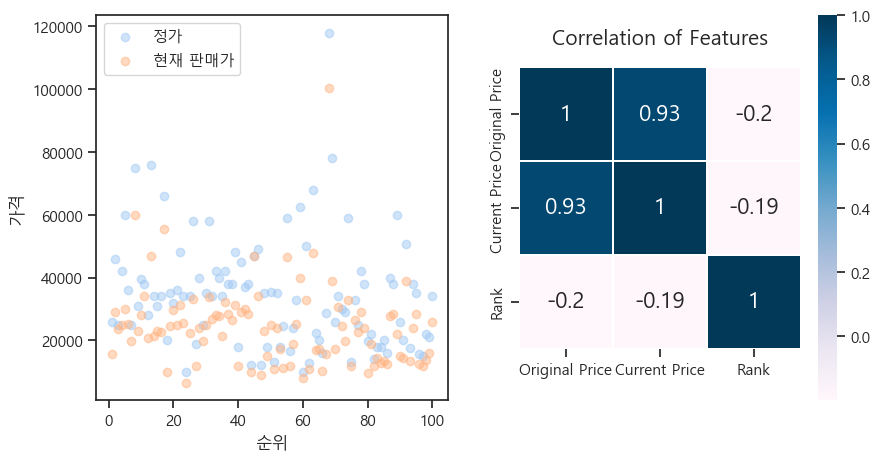

In [22]:
print("현재 판매가와 순위와의 상관관계")
data = {"Original Price":int_original_list,"Current Price":int_current_list,"Rank": rank_list,}
df =pd.DataFrame(data)
plt.figure(figsize = (10,5))
grid = plt.GridSpec(1,2)
# 산점도로 시각화
plt.subplot(grid[0,0])
plt.scatter(rank_list, int_original_list, alpha= 0.5, label = "정가")
plt.scatter(rank_list, int_current_list, alpha= 0.5, label = "현재 판매가")
plt.xlabel("순위")
plt.ylabel("가격")
plt.legend()
print(df.corr(method="pearson"))

# 위 내용 히트맵으로 시각화
colormap = plt.cm.PuBu
plt.subplot(grid[0,1])
plt.title("Correlation of Features", y = 1.05, size = 15)
sns.heatmap(df.astype(float).corr(), linewidths = 0.1, vmax = 1.0,
           square = True, cmap = colormap, linecolor = "white", annot = True, annot_kws = {"size" : 16})